In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Train, Test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pickle', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pickle', 'rb') as file:
    y_scaler = pickle.load(file)

In [4]:
df = pd.read_csv("../bin/data_process.csv")

In [5]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['precio_contado', 'concesionario', 'par', 'batalla', 'deposito', 'cilindrada', 'num_cilindros', 'peso',
                       'aceleracion', 'volumen', 'velocidad_max', 'capacidad_maletero', 'ano_matriculacion', 'num_plazas',
                      'garantia', 'num_marchas', 'provincia', 'comunidad_autonoma'], axis=1)  
y = df['precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [6]:
modelos = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "adaboost": AdaBoostRegressor(),
    "kneighbors": KNeighborsRegressor(),
    "linear_regressor": LinearRegression(),
    "svr": SVR()
}

In [7]:
%%time
resultados = []

for regresor, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    
    y_pred = modelo.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
    y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
    
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
    resultados.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by = "R2_score", ascending = False)

CPU times: total: 3.8 s
Wall time: 3.78 s


In [8]:
df_resultados

,Nombre_modelo,MAE,MSE,R2_score
0,random_forest,2397.052202,1.501912e+07,0.916442
2,gradient_boosting,2896.203626,1.842698e+07,0.897482
6,svr,3009.496073,2.268404e+07,0.873798
4,kneighbors,3171.578608,2.466644e+07,0.862769
1,decision_tree,3266.640917,3.010755e+07,0.832498
5,linear_regressor,4006.850385,3.474231e+07,0.806713
3,adaboost,5252.647544,4.283199e+07,0.761706


modelo: (0.4957198937830074) 
potencia_cv: (0.16280000174759462) 
antiguedad_coche: (0.1469328285205839) 
log_kilometraje: (0.11611585309372502) 
tipo_cambio: (0.03385190292986585) 
marca: (0.023444079653217556) 
distintivo_ambiental_ECO: (0.0049294621499033475) 
distintivo_ambiental_C: (0.0036888583149553753) 
combustible_Gasolina: (0.003589003769434157) 
num_puertas: (0.003448951577095304) 
combustible_Híbrido Enchufable: (0.003051295178790504) 
combustible_Eléctrico: (0.002271163154492195) 
distintivo_ambiental_B: (0.00012111972307324322) 
combustible_Gasolina/gas: (3.163247812910662e-05) 
combustible_Gas: (3.953926132441139e-06) 


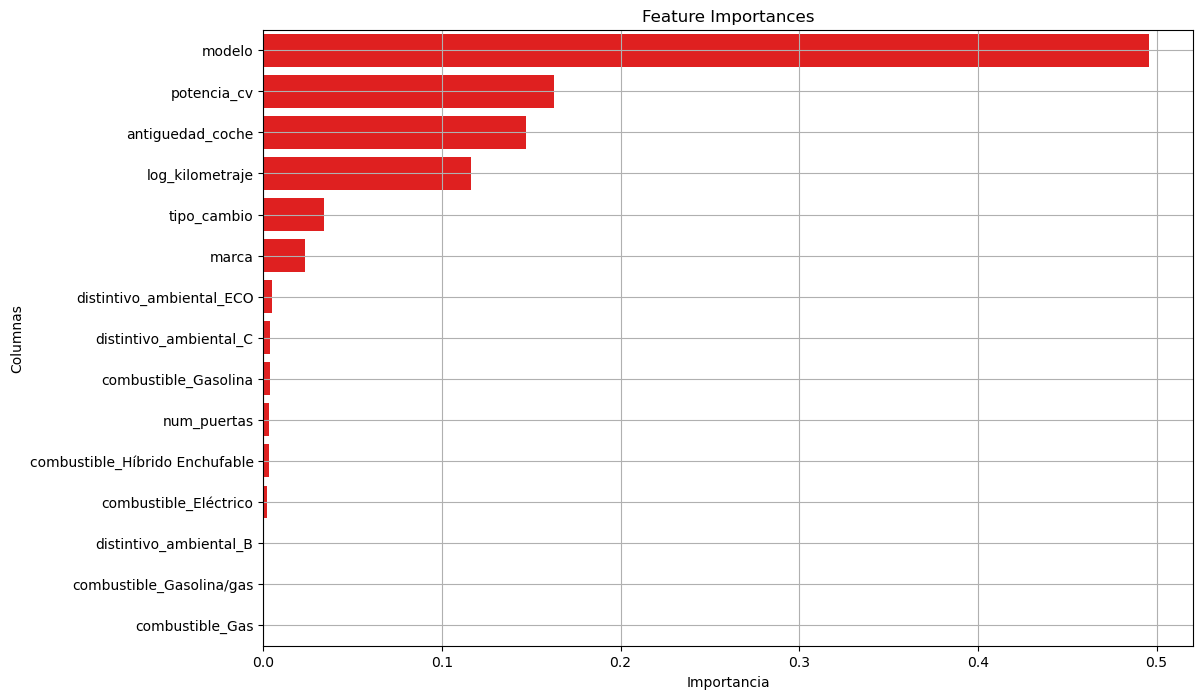

CPU times: total: 5.2 s
Wall time: 5.6 s


In [9]:
%%time
# Modelo de RandomForest para obtener Feature Importance
model = RandomForestRegressor(n_estimators = 250,
                               random_state = 33)
# Entrenamos el modelo
model.fit(x, y)

# Calculamos Feature Importance
importances = model.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [19]:
%%time

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)}



params = {"n_estimators"           : [100, 150],
          "criterion"              : ["squared_error", "absolute_error"], 
          "max_depth"              : [10, 15],
          "max_leaf_nodes"         : [90, 120],
          "min_samples_split"      : [2, 10],
          "random_state"           : [33]} 

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "R2",
                           n_jobs     = -1        ,
                           verbose    = 3)

model_result = grid_solver.fit(x, y)

print(model_result.cv_results_["mean_test_MAE"].mean())
print(model_result.cv_results_["mean_test_MSE"].mean())
print(model_result.cv_results_["mean_test_R2"].mean())

print("*" * 100)

print(model_result.best_score_)
print(model_result.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
-0.24394431137857386
-0.1245875991024922
0.8734665808004957
****************************************************************************************************
0.8807678382087264
{'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 33}
CPU times: total: 1.62 s
Wall time: 10min 56s


In [21]:
best_params = {'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 33}

In [23]:
mejor_modelo = RandomForestRegressor(**best_params)

mejor_modelo.fit(x, y)

RandomForestRegressor(max_depth=15, max_leaf_nodes=120, min_samples_split=10,
                      random_state=33)

modelo: (0.5229938425532787) 
potencia_cv: (0.16618563590511998) 
antiguedad_coche: (0.14186839723128858) 
log_kilometraje: (0.1041929278640141) 
tipo_cambio: (0.03419079170608613) 
marca: (0.016817148023818333) 
distintivo_ambiental_ECO: (0.004091314827915452) 
distintivo_ambiental_C: (0.0028639514952786987) 
combustible_Híbrido Enchufable: (0.001978074228198673) 
combustible_Gasolina: (0.0016302278852576293) 
combustible_Eléctrico: (0.0016150992851486675) 
num_puertas: (0.0015132926747637168) 
distintivo_ambiental_B: (5.929631983131822e-05) 
combustible_Gas: (0.0) 
combustible_Gasolina/gas: (0.0) 


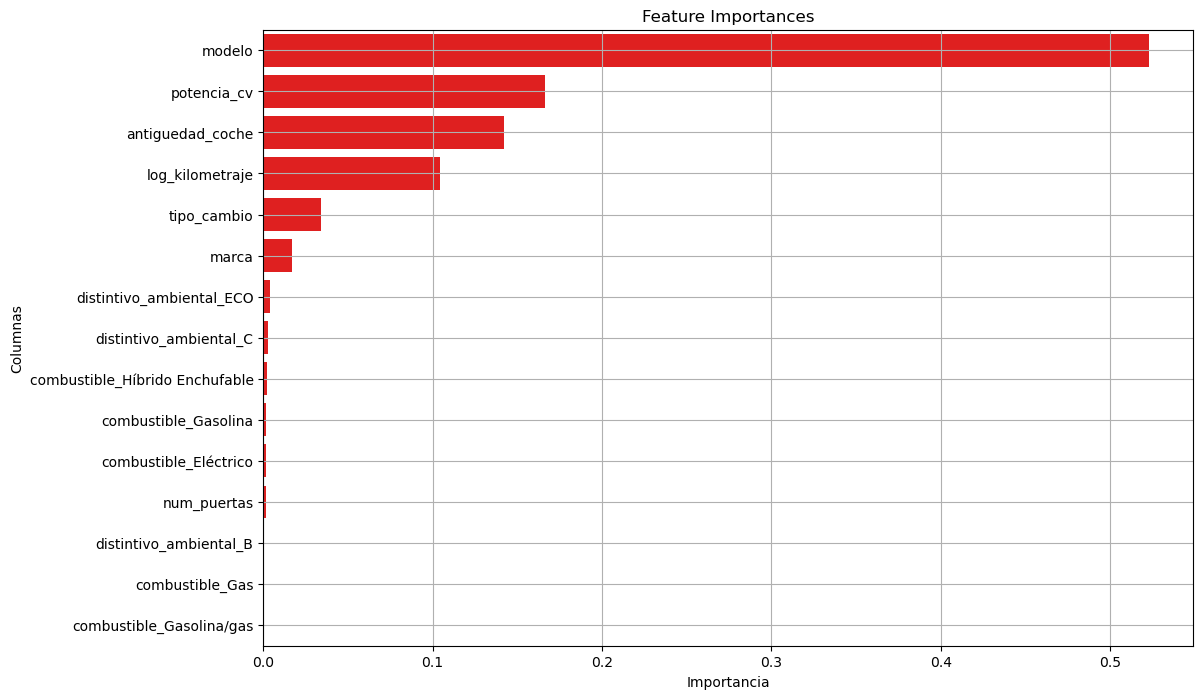

CPU times: total: 219 ms
Wall time: 327 ms


In [25]:
%%time
# Calculamos Feature Importance
importances = mejor_modelo.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()

plt.savefig('../bin/imagenes/feature_importance.png')

plt.show()

In [27]:
#Crear una carpeta para guardar el modelo

os.makedirs("modelo", exist_ok=True)

with open("modelo/mejor_modelo.pkl", "bw") as file:
    pickle.dump(mejor_modelo, file)